# Understanding the spread of COVID-19 based on European traffic data during summer

## 1. Introduction

### 1.1. Data

- Our World in Data COVID-19 dataset
    - Data on deaths in different countries.


- Google's traffic data 
    - Google provides anonymized insights from products such as Google Maps for researchers to help them to make critical analysis to combat COVID-19. 
    - Google has divided their traffic data into six traffic components: 
        1. retail \& recreation
            - places like restaurants, cafes, shopping centers, theme parks, museums, libraries and movie theaters
        2. grocery \& pharmacy
            - places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores and pharmacies
        3. parks
            - places like national parks, public beaches, marinas, dog parks, plazas and public gardens
        4. transit stations
            - places like public transport hubs such as subway, bus and train stations
        5. workplaces 
            - places of work
        6. residential 
            -  places of residence
     
  - These components do not tell anything how much time people spend in each section on average but they still give a lot of information how people's traffic behavior changed during the pandemic
 
 - The traffic data's baseline is counted as a median value of multiple days. Day-to-day changes should not be emphasized too much because they are effected on many different factors, f.e. the weather and public events.  




### 1.2. Moral behind the Bayesian model


- Getting the traffic data down slows down the spread of the virus. 
    - Several articles (Ferretti et al 2020, ECDC report, LSHTM report) have pointed out pre-symptomatic and asymptomatic  infections  play  a  significant  role  in  the  spread  of  COVID-19.  Indeed,  this observation  is  an  argument  it  may  not  be  enough  to  get  the  symptomatic  cases  to  stay at  home. Also  governmental  restrictions  should  be  implemented  to  get people’s movement down and furthermore the pandemic under control.
    - Essentially, the reason to implement non-pharmaceutical interventions is to get people's traffic data down!


- There are multiple reasons why it makes sense to analyse European countries in this research
    - COVID-19 hit European countries badly during autumn
    - European governments have similar capabilities to restrict their citizens movement in comparison to many countries, f.e. China
    - European countries adapted suppression strategy instead of mitigation one
    
    
- There are many major differences between European countries which effect on the spread of COVID-19
    - Examples: different age distributions, different population densities in cities, cultural differences
    - Therefore comparisons between European countries should be avoided

    
- The COVID-19-case data is not reliable at least as the only measure about the development of the epidemic. COVID-19-death data has many benefits compared to the COVID-19 case data! 
    - The amount of testing varies a lot between countries
    - Also using death data over infected data has the benefit that deaths measures much better country's success against the epidemic than infections
    





### 1.3. Motivation, research goals


1. To create a model which predicts the spread of the epidemic well based on the traffic data and data on deaths.

2. Based on the created model, trying to understand which of these Google's traffic components predicted the spread of COVID-19 in different European countries


### 1.4.  Structure



1. Introduction
    - Describes the essentials of this notebook
2. Getting an overview how COVID-19-cases and people's traffic behavior developed during the pandemic
3. Bayesian model

### 1.5. Libraries used in this notebook

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pystan
from scipy.integrate import odeint

import stan_utils

### 1.6. Parameters which need to be defined manually

- All the parameters, which need to be defined manually, are here


- During text there are detailed explanations what these parameters are

In [2]:
#############################################################################

# There is COVID-19-data from February until now
observations_start_date = datetime.datetime(2020, 2, 1, 0, 0)
observations_end_date = datetime.datetime(2020, 11, 15, 0, 0)

# However, the data analysis of this notebook concentrates on autumn months, i.e. on so called tail
tail_start_date = datetime.datetime(2020, 7, 1, 0, 0)


#############################################################################

# European countries ordered by population
european_countries = [
    'Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 
    'Ukraine', 'Poland', 'Romania','Netherlands', 'Belgium', 
    'Greece', 'Sweden', 'Portugal', 'Hungary', 'Belarus', 
    'Austria', 'Switzerland', 'Bulgaria', 'Serbia', 'Denmark', 
    'Finland', 'Norway', 'Ireland', 'Croatia', 'Moldova', 
    'Bosnia and Herzegovina', 'Lithuania', 'Slovenia', 'Estonia' ]


#############################################################################

# Window size for convolution
w = 7

# Death limit
d = 1

In [3]:
# Follows directly from manual definitions 
num_countries = len(european_countries)
whole_interval_len = (observations_end_date - observations_start_date).days 
tail_interval_len = (observations_end_date - tail_start_date).days 
date_list = [observations_start_date + datetime.timedelta(days=x) for x in range(whole_interval_len)]

print("There are " + str(num_countries) + " European countries analysed in this notebook.")
print("The length of the whole interval: " + str(whole_interval_len))
print("The length of the tail interval: " + str(tail_interval_len))

There are 29 European countries analysed in this notebook.
The length of the whole interval: 288
The length of the tail interval: 137


#### Definition: Autumn interval $\tau_{\text{autumn}}$

Let's denote the autumn interval with $\tau_{\text{autumn}} = \{ 0,1,2, \dots, 75 \}$. Indeed $t = 0$ corresponds the date 1.9.2020, $t = 1$ corresponds the date 2.9.2020 and so on.

### 1.7. Adding previously cleaned data to dataframes 

#### Dataframe df_countries

- The length of this dataframe is 'num_countries'. Indeed, for each country there is one row.

In [4]:
# A dataframe sorted by countries

dtypes_countries = np.dtype([
          ('country', str),
          ('population', int),
          ('population_in_millions', int),
          ])

df_countries = pd.DataFrame(pd.read_csv('Cleaned_dataframes/df_countries.csv', dtype=dtypes_countries))

# Show the dataframe
df_countries

,country,population,population_in_millions
0,Germany,83783945,84
1,United Kingdom,67886004,68
2,France,65273512,65
3,Italy,60461828,60
4,Spain,46754783,47
5,Ukraine,43733759,44
6,Poland,37846605,38
7,Romania,19237682,19
8,Netherlands,17134873,17
9,Belgium,11589616,12


#### Dataframe df_days_by_countries

- All the days to which there exists traffic and infected data to each country


- The length of the dataframe equals 'num_countries' * 'whole_interval_len'



In [5]:
# A countrywise sorted dataframe s.t. for each day on the time interval of each country there is a row 

dtypes_days_by_countries = np.dtype([
          ('country', str),  # country name
          ('date', str), # current date. This will become datetime-time using parse_dates!
          ('new_deaths', int), # new deaths on that date
          ('new_deaths_smooth', int), # smoothened new deaths on that date
          ('total_deaths_per_million', float), # how many deaths per million has occured until that date
          ('traffic_retail', float), # retail and recreation traffic on that date
          ('traffic_supermarket', float), # supermarket and pharmacy traffic on that date
          ('traffic_parks', float),  # park traffic on that date
          ('traffic_transit_stations', float), # transit station traffic on that date
          ('traffic_workplaces', float), # workplace traffic on that date
          ('traffic_residential', float), # residential traffic on that date
          ('traffic_retail_smooth', float),  # park traffic on that date
          ('traffic_supermarket_smooth', float), # transit station traffic on that date
          ('traffic_transit_stations_smooth', float), # workplace traffic on that date
          ('traffic_workplaces_smooth', float), # residential traffic on that date
          ])

df_days_by_countries = pd.DataFrame(pd.read_csv('Cleaned_dataframes/df_days_by_countries.csv', dtype=dtypes_days_by_countries))   

# Change the date-column from string-type to datetype
df_days_by_countries['date'] = pd.to_datetime(df_days_by_countries['date'], format='%Y-%m-%d')


# pd.set_option('display.max_rows', None)
# Show the dataframe
df_days_by_countries

,country,date,new_deaths,new_deaths_smooth,total_deaths,traffic_retail,traffic_supermarket,traffic_parks,traffic_transit_stations,traffic_workplaces,traffic_residential,traffic_retail_smooth,traffic_supermarket_smooth,traffic_transit_stations_smooth,traffic_workplaces_smooth
0,Germany,2020-02-01,0,0,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,Germany,2020-02-02,0,0,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,Germany,2020-02-03,0,0,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,Germany,2020-02-04,0,0,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,Germany,2020-02-05,0,0,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8637,Estonia,2020-11-20,1,1,87.0,0.85,1.00,0.82,0.73,0.83,1.07,0.88,1.01,0.77,0.86
8638,Estonia,2020-11-21,0,1,87.0,0.81,1.00,0.86,0.72,0.91,1.04,0.87,1.00,0.76,0.86
8639,Estonia,2020-11-22,1,1,88.0,0.84,0.99,1.08,0.73,0.89,1.02,0.86,1.00,0.75,0.86
8640,Estonia,2020-11-23,4,1,92.0,0.87,0.97,0.96,0.76,0.84,1.07,0.86,0.99,0.75,0.86


## 2. Getting an overview how COVID-19-cases, -deaths and people's traffic behavior developed during the pandemic

### 2.1. Plot all Google's traffic components and also death and infected data countrywise

- The vertical black line represents when the tail of the pandemic starts 

Germany
traffic in retail and recreation


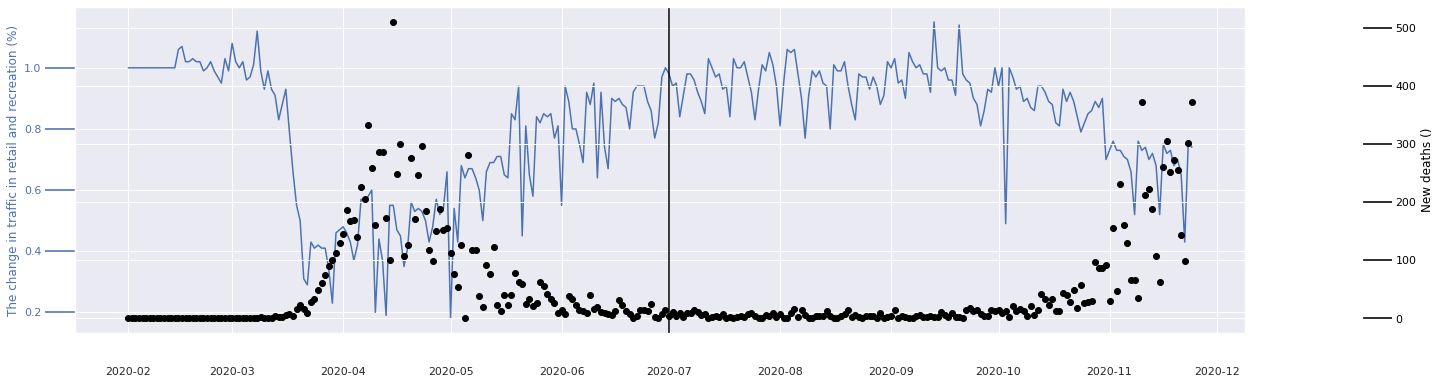

traffic in supermarkets and pharmacy


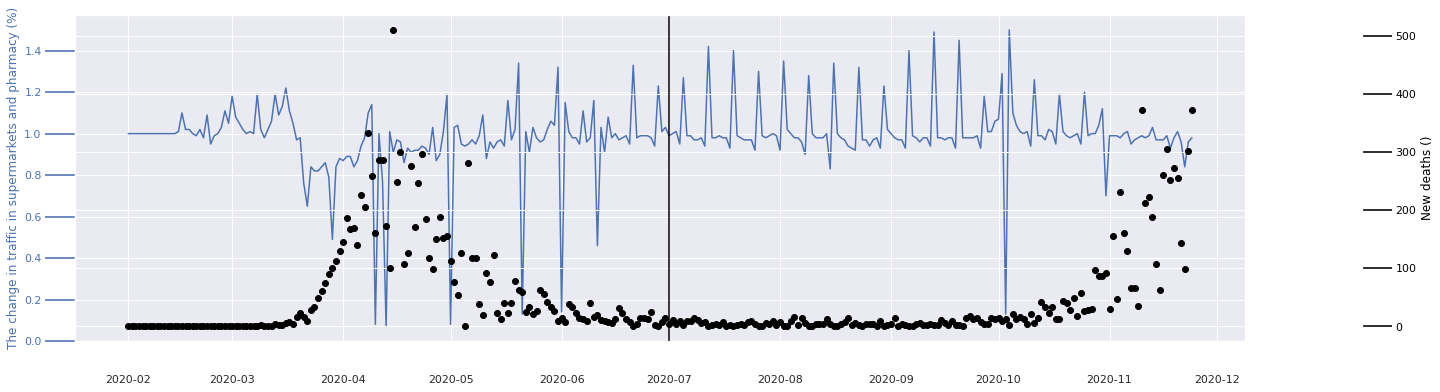

traffic in parks


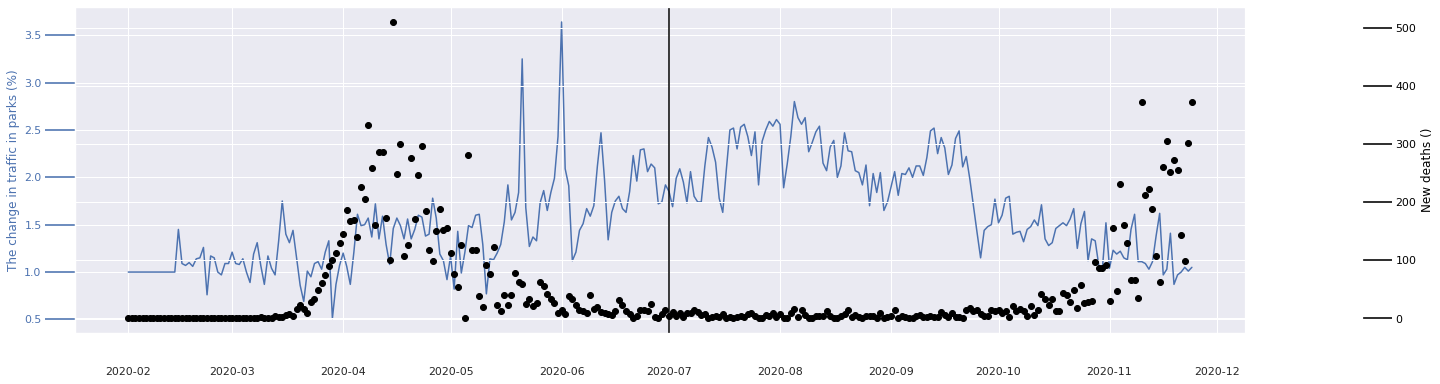

traffic in transit stations


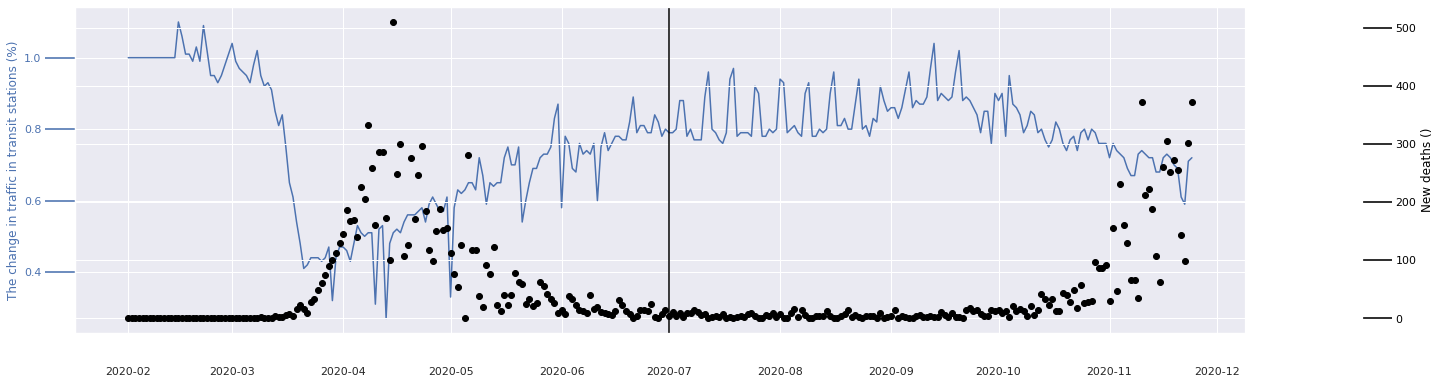

traffic in workplaces


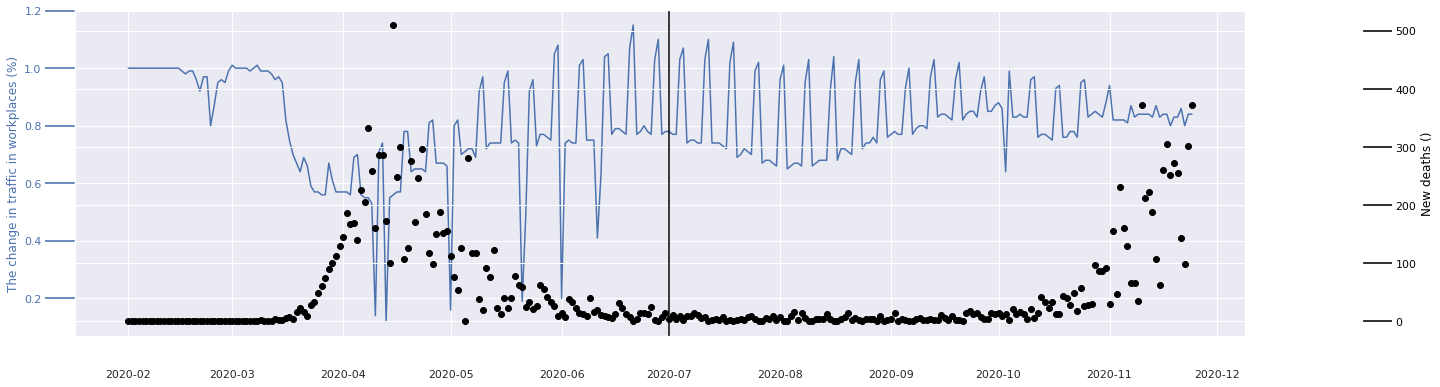

traffic in residential ares


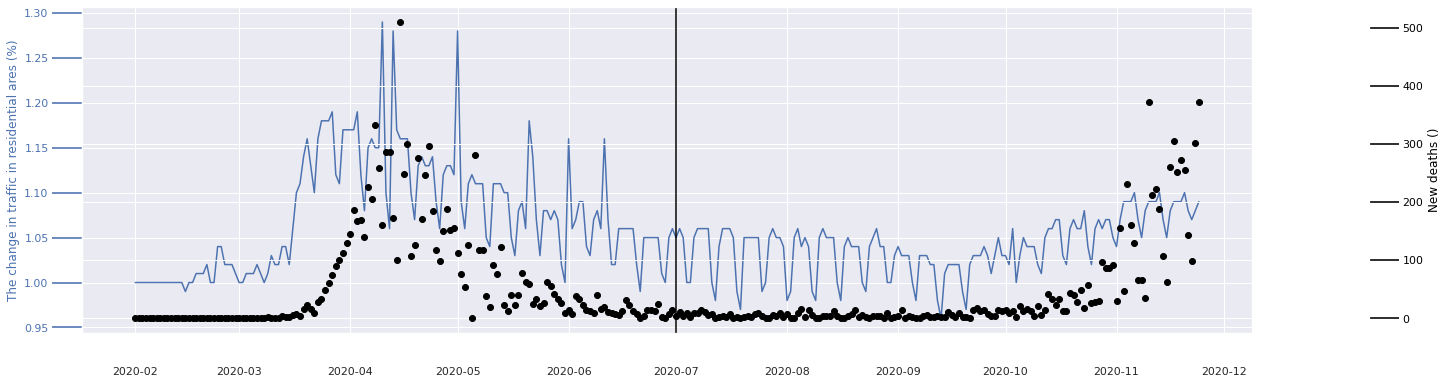

Spain
traffic in retail and recreation


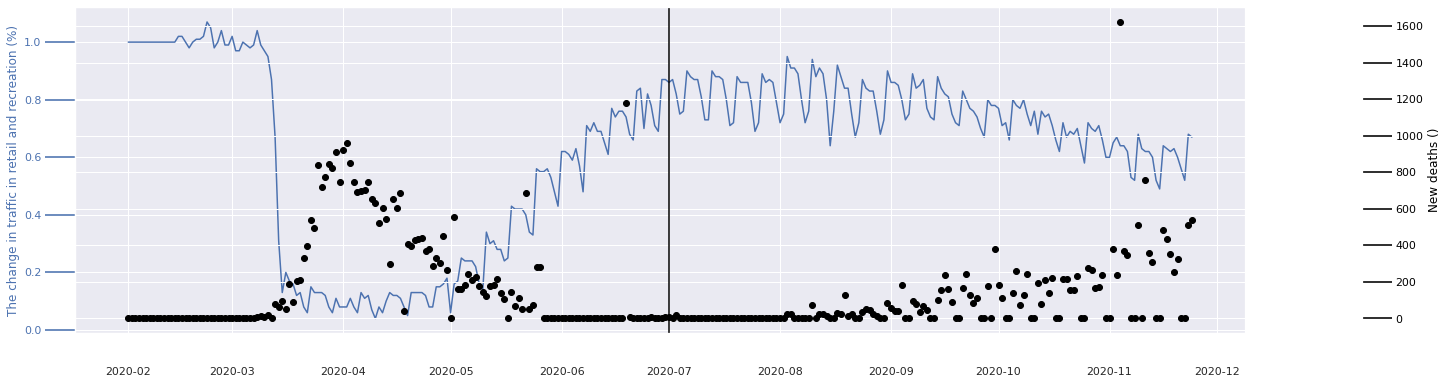

traffic in supermarkets and pharmacy


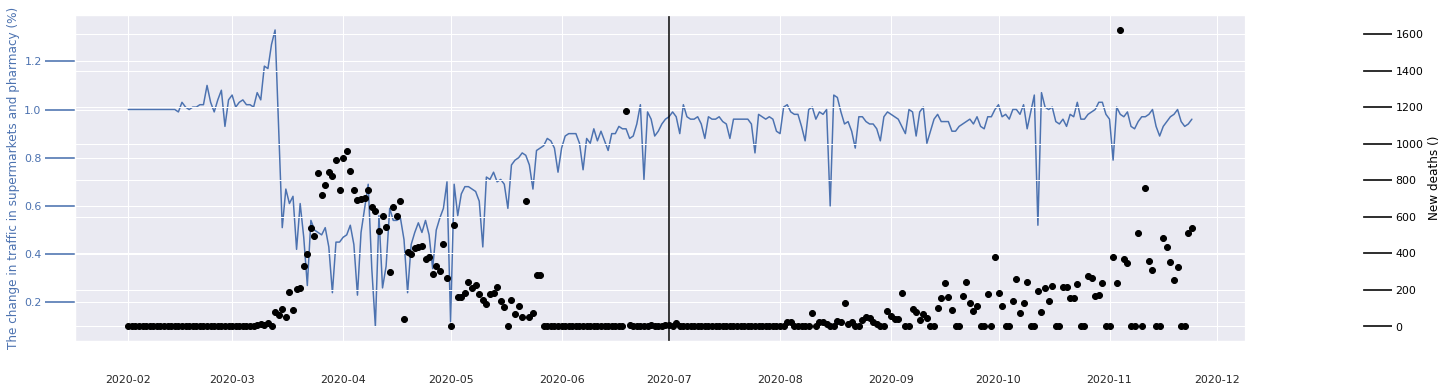

traffic in parks


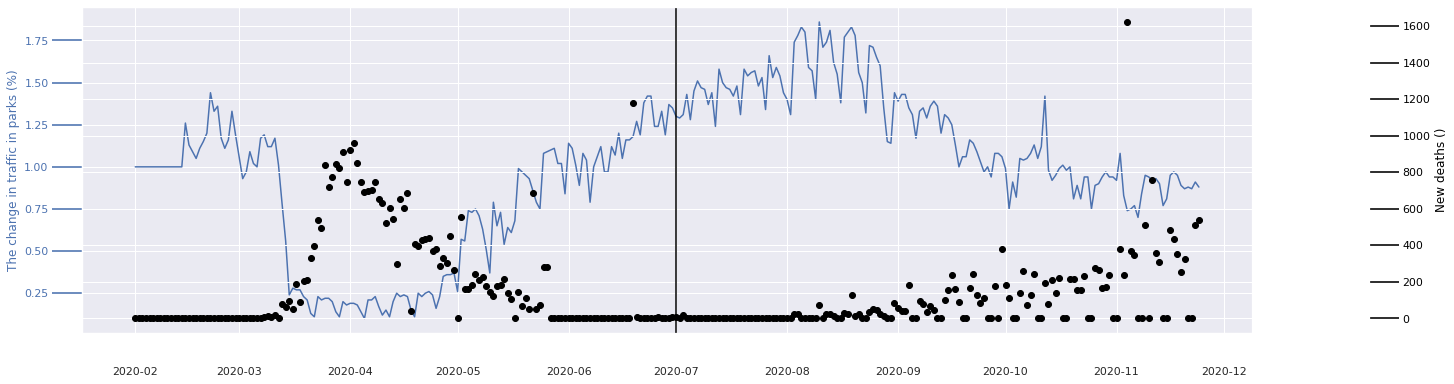

traffic in transit stations


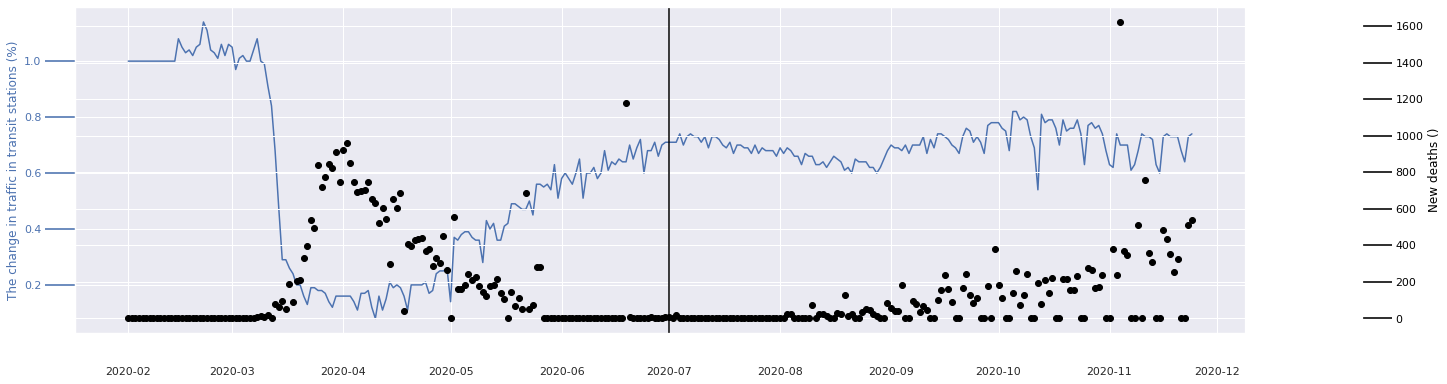

traffic in workplaces


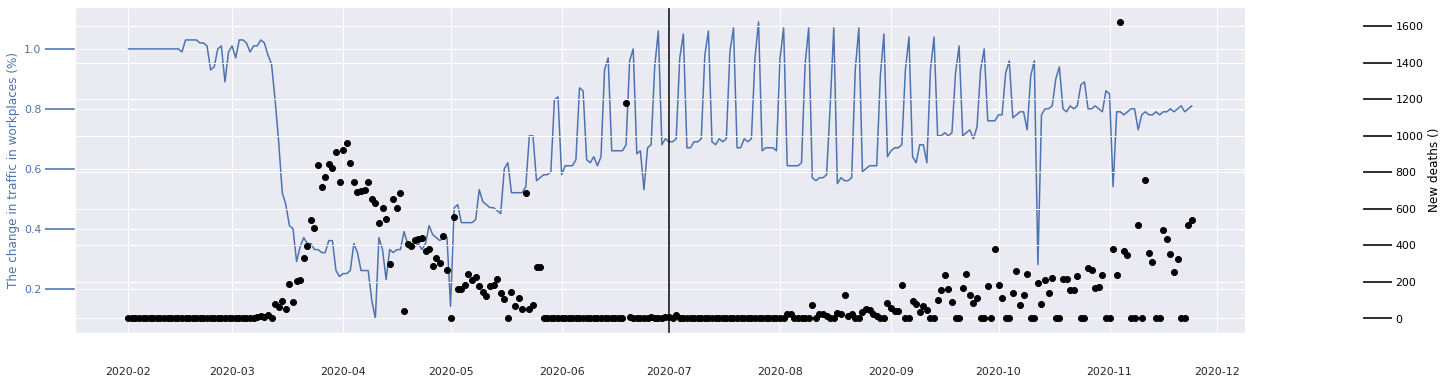

traffic in residential ares


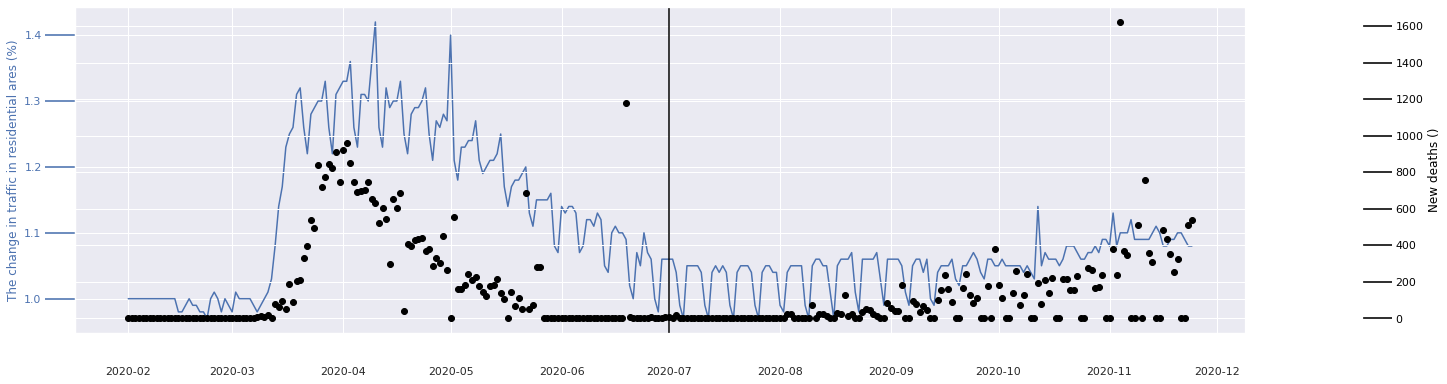

In [6]:
# Define categories which are plotted
traffic_components = ['traffic_retail', 'traffic_supermarket', 'traffic_parks', 
                      'traffic_transit_stations', 'traffic_workplaces', 'traffic_residential'
                     ]

description = ['traffic in retail and recreation', 'traffic in supermarkets and pharmacy', 'traffic in parks',
               'traffic in transit stations', 'traffic in workplaces', 'traffic in residential ares'
              ]


# for i in range(num_countries): # Loop over each country
for i in [0,4]: # Example countries: Germany and Spain

    # Define the current country, a temporary dataframe of the country and x-axis (dates)
    current_country = european_countries[i]
    df_current = df_days_by_countries[(df_days_by_countries['country'] == current_country)]
    x = df_current['date'].tolist() 
    
    print('\033[1m' + current_country)
    
    # Loop over each traffic component
    for j in range(len(traffic_components)):

        # Define y-components which are going to be plotted in one figure
        y_traffic = df_current[traffic_components[j]].tolist()
        y_deaths = df_current['new_deaths'].tolist()

        # Define the figure and different y-axis (there are 3 in total: traffic, infected, deaths)
        fig, host = plt.subplots(figsize=(26, 6))
        fig.subplots_adjust(right=0.75)
        par1 = host.twinx()

        # Set the most right one y-axis to right
        par1.spines["right"].set_position(("axes", 1.1))

        # Plot the traffic, infected and death data
        p1, = host.plot(x, y_traffic, "b-", label='The change in ' + description[j] +  ' (%)' )
        p2, = par1.plot(x, y_deaths, marker = 'o', linestyle='', color = "black", label="New deaths ()")

        # Define the texts
        host.set_ylabel('The change in ' + description[j] +  ' (%)')
        par1.set_ylabel("New deaths ()")

        # Text on the axis with the correct color
        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())

        # Make little spikes for different y-axis
        tkw = dict(size=30, width=1.6)
        host.tick_params(axis='y', colors=p1.get_color(), **tkw)
        par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
        host.tick_params(axis='x', **tkw)

        plt.axvline(tail_start_date, color='black')
        
        print('\033[0m' + description[j])
        plt.show()

### Conclusions

- Based on previous plots, clearly residential traffic does not impact negatively on the spread of COVID-19. The effect of other traffic components will be analysed more detailed and residential traffic data is not analysed any more in this project.
 

- It is difficult to analyse the impact of different traffic components to the spread of COVID-19 based on the first local maximum of the epidemic (in most countries it happend on March or on April)
    
    - Almost in every European country all the traffic data components except residential traffic went strongly down at the same time. Therefore, it is difficult to say which traffic component truely mattered based on the beginning of the pandemic.
    
    
- Therefore, let's concentrate the analysis what happend later during the second wave, i.e. concentrate on the tail of the pandemic, summer and autumn which is defined to start on 1.6.2020!

## Bayesian model

### Essential theory behind the model

Let's start using SEIR-model. 

In this extended SEIR-model, the population $N \in \mathbb{N}$ is divided in four groups: susceptibles $S(t) \in \mathbb{N}$, exposed $E(t) \in \mathbb{N}$, infected $I(t) \in \mathbb{N}$ and removed $R(t) \in \mathbb{N}$. Notice that the group removed $R$ includes everyone who is either recovered from the disease, isolated or died because of it. The changes of these groups can be described by the following equations:

\begin{equation}
\frac{\partial S}{\partial t} = - \frac{\beta S I }{N}
\end{equation}

\begin{equation}
\frac{\partial E}{\partial t} =  \frac{\beta S I}{N} - \frac{E}{D_e}
\end{equation}

\begin{equation}
\frac{\partial I}{\partial t} =  \frac{E}{D_e} - \frac{I}{D_i}
\end{equation}

\begin{equation}
\frac{\partial R}{\partial t} =  \frac{I}{D_i}
\end{equation}

$D_e \in \mathbb{R}$ is the latent period of the disease. 
Furthermore, $D_i \in \mathbb{R}$ is the period how long both symptomatic and asymptomatic cases are going to spread the disease before getting noninfectious, dead or isolated from other population. These values are fixed in our model.

Furthermore, $\beta(t)$ is the average daily rate how many people an infected person meets inside the population. A central question in this project is how $\beta(t)$ should be defined. We introduce three different definitions which leads into three different models.

The daily death data is assumed to be Poisson distributed. 
Therefore, the parameters of this model are estimated with the likelihood function 
$\prod_{i=1}^{t} \frac{e^{- \lambda_i} \lambda_i^{x_i}}{x_i !}$ where 
$x_i$ is the smoothened deaths at day $i$. Also, $\lambda_i = \frac{\alpha I}{D_i}$ is the rate of the Poisson distribution where $\alpha \in [0,1]$ is the proportion of infected who die. 

We will use training set in our model data starting from the beginning of July. The last for weeks in November are used four prediction set.



# Experiments



In [7]:
# global seed for stable experiments
seed = 1234

## Simulated dataset
Stan simulator for data. For testing our model we developed stan simulator which generates data from SEIR model.

In [8]:
def simulate_deaths(model_data):
    '''
    adds simulated deaths to dictionary containing training data
    model_data, data used for training the model except deaths
    constant term: params[0]
    traffic component slopes params[1:]
    returns the analytical number of deaths
    '''
    sm_generator = stan_utils.StanModel_cache("./seir_simulator.stan")
    gen_fit = sm_generator.sampling(model_data, algorithm="Fixed_param", seed=seed)
    gen_samples = gen_fit.extract(permuted=True)
    deaths = gen_samples['deaths'][0]
    model_data["deaths"] = deaths.astype(int)
    return np.mean(gen_samples['deaths'], axis=0)

### Generating traffic components

In [9]:
def traffic_component_gen(t, shape, loc, floor, inversed=False):
    '''
    Generate traffic_components
    '''
    exp_val = np.exp((np.array(t) - loc + np.random.normal(size=len(t)))* shape)
    sigmoid = exp_val / (exp_val + 1)
    if inversed:
        sigmoid = sigmoid * floor + floor
        return -1 * sigmoid + 1 + floor
    sigmoid = sigmoid * floor + (1 - floor)
    return sigmoid

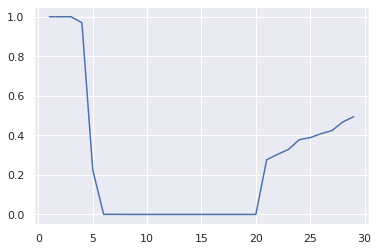

In [21]:
ts = np.array(list(range(1, 30)))
traffic = np.concatenate([traffic_component_gen(ts[:20], 5, 4, 1, True), traffic_component_gen(ts[20:], 0.1, 30, 1, False)])
plt.plot(ts, traffic)
plt.show()

Testing and plotting

In [11]:
def shadedplot(x, dat, fill=True, label='', color='b'):
    ret = np.empty((3, dat.shape[1]))
    ret[0, :] = np.quantile(dat, 0.5, axis=0)
    ret[1, :] = ret[0, :] - np.quantile(dat, 0.25, axis=0)
    ret[2, :] = ret[0, :] + np.quantile(dat, 0.75, axis=0)
    p = plt.plot(x, ret[0, :], label=label, color=color)
    if fill:
        plt.fill_between(x, ret[1, :], ret[2, :], color=color, alpha=0.25)

def test_model(data, model, traffic, traffic_coeffs):
    test_data = data.copy()
    test_data['traffic'] = traffic
    test_data['traffic_coeff'] = traffic_coeffs
    test_data['n_tcomponents'] = len(traffic_coeffs) - 1
    deaths_hat = simulate_deaths(test_data)
    fit = model.sampling(test_data, seed=seed)
    samples = fit.extract(permuted=True)
    print(fit)
    plt.plot(data["t_training"], deaths_hat, 'r', label="generating model")
    plt.plot(data["t_training"], test_data['deaths'], '*r', label="training_data")
    shadedplot(data["t_training"], samples['deaths_hat'], label="model")
    plt.legend()
    plt.show()

In [12]:
# Boilerplate data for model testing

ts = list(range(1, 30))
n_prediction = 0
n_training = len(ts)
N = 5000000
e0 = 10
i0 = 1000
r0 = 10
y0 = [N - e0 - i0 - r0, e0, i0, r0]
t0 = 0
D_e = 5.3
D_i = 5
alpha = 0.003

seir_data = {
    "n_training": n_training,
    "n_prediction": 0,
    "n_tcomponents": 0,
    "y0": y0,
    "t0": t0,
    "t_training": ts,
    "t_prediction": np.empty(0),
    "N": N,
    "D_e": D_e,
    "D_i": D_i,
    "alpha": alpha,
}

In [13]:
sm = stan_utils.StanModel_cache("./seir_prior_check.stan")

Using cached StanModel


In [14]:
traffic

array([9.99993533e-01, 9.99424873e-01, 9.38490921e-01, 9.80843246e-01,
       3.94637290e-07, 8.35875113e-05, 2.94146263e-10, 1.59435902e-07,
       3.52538887e-10, 3.33066907e-14, 2.44249065e-15, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.02109480e-01, 3.38984519e-01, 3.05735238e-01, 3.53578830e-01,
       3.40660412e-01, 3.64666533e-01, 4.33706299e-01, 4.67669049e-01,
       4.91907425e-01])

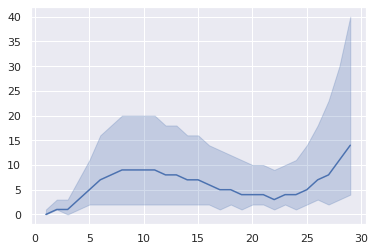

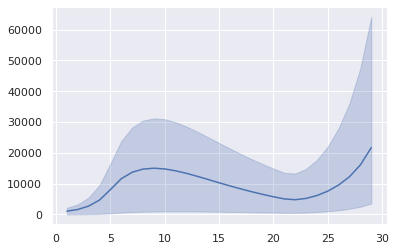

In [15]:
prior_check_data = seir_data.copy()
prior_check_data["traffic_coeff_means"] = np.array([0, 3])
prior_check_data["traffic_coeff_stds"] = np.array([0.1, 0.1])
prior_check_data["n_tcomponents"] = 1
prior_check_data["traffic"] = traffic.reshape(-1,1)
fit = sm.sampling(prior_check_data, algorithm="Fixed_param", seed=seed)
samples = fit.extract()
shadedplot(seir_data["t_training"], samples['deaths'], label="model")
plt.show()
shadedplot(seir_data["t_training"], samples['y'][:,:,2], label="model")

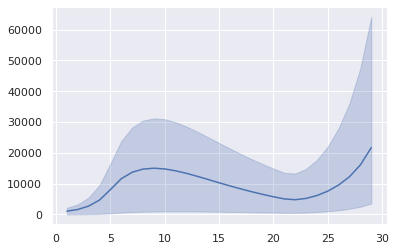

In [16]:
shadedplot(seir_data["t_training"], samples['y'][:,:,2], label="model")

### Naive model 1: $\beta$ is a constant 

In [20]:
sm = stan_utils.StanModel_cache("./seir_optimized.stan")

Using cached StanModel


Using cached StanModel
Inference for Stan model: anon_model_ced4dcd059b6ec08c94170e08fbee8c3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
traffic_coeff[1]   2.98  4.9e-4   0.02   2.95   2.97   2.98   2.99   3.01   1349    1.0
y[1,1]            5.0e6    0.52  19.16  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1350    1.0
y[2,1]            5.0e6    1.44  52.81  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1350    1.0
y[3,1]            5.0e6    3.35 123.01  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1351    1.0
y[4,1]            5.0e6    7.29  267.9  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1351    1.0
y[5,1]            5.0e6    15.2 558.89  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1352    1.0
y[6,1]            4.9e6   30.69 1128.6  4.9e6  4.9e6  4.9e6  4.9e6  4.9e6   1353    1.0
y[7,1]            4.9e6   60.25 2216.4  4.9e6  4.9e6  4.9e6  4.9e6  4.9e6   1353    

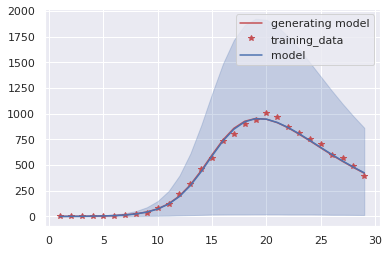

In [23]:
sm = stan_utils.StanModel_cache("./seir_optimized.stan")
traffic_coeff = np.array([3])
traffic = np.empty((seir_data["n_training"], 0))
test_model(seir_data, sm, traffic, traffic_coeff)

In [24]:
sm = stan_utils.StanModel_cache("./seir_model.stan")
traffic_coeff = np.array([3])
traffic = np.empty((seir_data["n_training"], 0))
test_model(seir_data, sm, traffic, traffic_coeff)

Using cached StanModel
Using cached StanModel


Process ForkPoolWorker-106:
Process ForkPoolWorker-104:
Process ForkPoolWorker-103:
Process ForkPoolWorker-108:
Process ForkPoolWorker-101:
Process ForkPoolWorker-102:
Process ForkPoolWorker-105:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-107:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **se

  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing

Traceback (most recent call last):
  File "/home/coldditch/projects/Corona_Bayesian/corona_env/lib/python3.8/site-packages/pystan/model.py", line 85, in _map_parallel
    map_result = pool.map(function, args)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/coldditch/projects/Corona_Bayesian/corona_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec

Process ForkPoolWorker-117:

KeyboardInterrupt
Process ForkPoolWorker-120:

Process ForkPoolWorker-119:
Process ForkPoolWorker-118:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/pyt

Traceback (most recent call last):
  File "/home/coldditch/projects/Corona_Bayesian/corona_env/lib/python3.8/site-packages/pystan/model.py", line 85, in _map_parallel
    map_result = pool.map(function, args)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):


### Model 2: $\beta = c_1 \tau_i + c_2,$ where $i \in \{1,2,3,4 \}$ 

Using cached StanModel
Inference for Stan model: anon_model_7ebaab76218e42c73b704b2810e1ebca.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
traffic_coeff[1] 3.7e-3  1.1e-3   0.03  -0.05  -0.02 9.9e-4   0.02   0.07    723    1.0
traffic_coeff[2]   3.49    0.01   0.34   2.81   3.27    3.5   3.71   4.14    752    1.0
y[1,1]            5.0e6   12.28 339.57  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6    765    1.0
y[2,1]            5.0e6   35.88 993.01  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6    766    1.0
y[3,1]            5.0e6   51.71 1435.9  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6    771    1.0
y[4,1]            5.0e6  139.75 3879.4  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6    771    1.0
y[5,1]            5.0e6  140.16 3905.6  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6    777    1.0
y[6,1]            5.0e6  132.52 3714.8  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6    786    

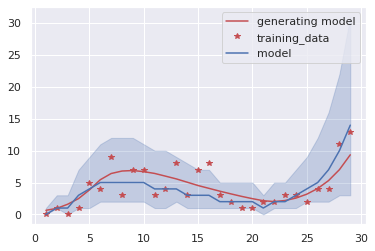

In [81]:
traffic = np.concatenate([traffic_component_gen(ts[:20], 5, 4, 1, True), traffic_component_gen(ts[20:], 0.1, 30, 1, False)])
traffic = traffic.reshape(-1, 1)
traffic_coeff = np.array([0, 3])
test_model(seir_data, sm, traffic, traffic_coeff)

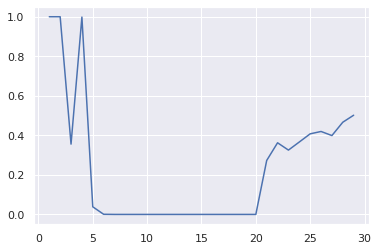

In [82]:
plt.plot(ts, traffic)
plt.show()

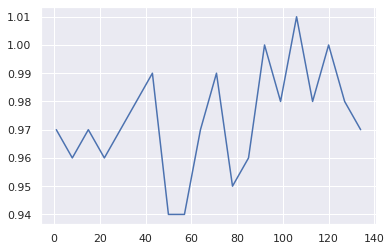

In [105]:
plt.plot(ts, traffic_supermarket_smooth)

In [113]:
list(range(n_training))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [114]:
def initial_guess(N, total_deaths_0, new_deaths_1):
    death_rate = 0.005
    
    r0 = total_deaths_0 * (1/death_rate)
    i0 = new_deaths_1 * (1/death_rate) * 0.6 * 5
    p0 = i0 * 0.4   # 2/5
    a0 = new_deaths_1 * (1/death_rate) * 0.4 * 5
    e0 = i0 + a0
    s0 = N - e0 - a0 - p0 - i0 - r0
    
    return [s0, e0, i0, r0]

current_country = 'Spain'

df_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                                  (df_days_by_countries['date'] >= tail_start_date)]

ts = []
deaths = []
traffic_retail_smooth = []
traffic_supermarket_smooth = []
traffic_transit_stations_smooth = []
traffic_workplaces_smooth = []


for i in range(tail_interval_len):
    if i % 7 == 0:
        ts.append(i+1)
        
        deaths.append(df_current['new_deaths'].tolist()[i])
        print(traffic_retail_smooth)
        traffic_retail_smooth.append(df_current['traffic_retail'].tolist()[i])
        traffic_supermarket_smooth.append(df_current['traffic_supermarket'].tolist()[i])
        traffic_transit_stations_smooth.append(df_current['traffic_transit_stations'].tolist()[i])
        traffic_workplaces_smooth.append(df_current['traffic_workplaces'].tolist()[i])
                
            
n_training = len(ts)

N = df_countries[(df_countries['country'] == current_country)]['population'].tolist()[0]

total_deaths_0 = df_current['total_deaths'].tolist()[0] # deaths occured until 1.7.2020
new_deaths_1 = deaths[1] # new smoothened deaths occuring 7.7.2020
y0 = initial_guess(N, total_deaths_0, new_deaths_1)

t0 = 0

D_e = 3
D_p = 2
D_i = 5
r = 0.4
r_a = 0.1
r_p = 1.25
alpha = 0.01

seir_data = {
    "n_training": n_training,
    "n_prediction": 0,
    "n_tcomponents": 0,
    "y0": y0,
    
    "t0": t0,
    "t_training": list(range(1, 1+n_training)),
    "t_prediction": np.empty(0),
    "traffic": np.empty((n_training, 0)),
    
    "N": N,
    
    "D_e": D_e,
    "D_i": D_i,
    "alpha": alpha,
    
    "D_e": D_e,
    "D_p": D_p,
    "D_i": D_i,
    "r": r,
    "r_a": r_a,
    "r_p": r_p,
    "alpha": alpha,
    
    "deaths": deaths,
    # "traffic": np.empty((n_training, 0))
}


[]
[0.86]
[0.86, 0.87]
[0.86, 0.87, 0.88]
[0.86, 0.87, 0.88, 0.86]
[0.86, 0.87, 0.88, 0.86, 0.87]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83, 0.86]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83, 0.86, 0.85]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83, 0.86, 0.85, 0.8200000000000001]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83, 0.86, 0.85, 0.8200000000000001, 0.77]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83, 0.86, 0.85, 0.8200000000000001, 0.77, 0.78]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83, 0.86, 0.85, 0.8200000000000001, 0.77, 0.78, 0.77]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83, 0.86, 0.85, 0.8200000000000001, 0.77, 0.78, 0.77, 0.74]
[0.86, 0.87, 0.88, 0.86, 0.87, 0.91, 0.91, 0.84, 0.83, 0.86, 0.85, 0.8200000000000001, 0.77, 0.

In [115]:
fit = sm.sampling(seir_data, seed=seed)

### Model 3: $\beta = c_1 \tau_i + c_2 \tau_j + c_3,$ where $i \neq j \in \{1,2,3,4 \}$ 

Using cached StanModel
Inference for Stan model: anon_model_7ebaab76218e42c73b704b2810e1ebca.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
traffic_coeff[1]   1.74  7.8e-3   0.32   1.14   1.53   1.74   1.95   2.38   1654    1.0
traffic_coeff[2]   0.56    0.02   0.73  -0.85   0.05   0.54   1.06   2.02   1054    1.0
traffic_coeff[3]   0.57    0.02   0.74  -0.88   0.06   0.58   1.08   1.97   1111    1.0
y[1,1]            5.0e6     5.3 216.36  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1665    1.0
y[2,1]            5.0e6   13.62 555.21  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1661    1.0
y[3,1]            5.0e6   29.91 1217.2  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1657    1.0
y[4,1]            5.0e6   40.42 1651.4  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1669    1.0
y[5,1]            5.0e6   57.23 2350.2  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1686    

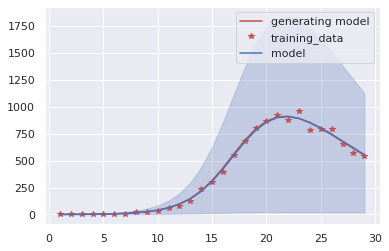

In [18]:
traffic = np.array(traffic_component_gen(ts, 2, 3, 0.5, True)).reshape(-1,1)
traffic = np.concatenate([traffic,traffic], axis=1)
traffic_coeff = np.array([2, 0.2, 0.5])
test_model(seir_data, sm, traffic, traffic_coeff)

In [ ]:
all_fits_2 = []
filter_step = 7
# for current_country in european_countries:
for current_country in ['Germany']: # temparately

    ###############################################################
    # Deaths
    deaths_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                      (df_days_by_countries['date'] >= tail_start_date)]['new_deaths_smooth'].tolist()

    deaths_current = deaths_current[::filter_step]

    print(len(deaths_current))
    print(deaths_current)

    
    ###############################################################
    # Traffic components

    ##############
    retail_data_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                      (df_days_by_countries['date'] >= tail_start_date)]['traffic_retail'].tolist()
    retail_data_current = retail_data_current[::filter_step]
    print(len(retail_data_current))
    print(retail_data_current)

    ##############
    grocery_data_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                      (df_days_by_countries['date'] >= tail_start_date)]['traffic_supermarket'].tolist()
    grocery_data_current = grocery_data_current[::filter_step]
    print(len(grocery_data_current))
    print(grocery_data_current)


    ##############
    transport_data_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                      (df_days_by_countries['date'] >= tail_start_date)]['traffic_transit_stations'].tolist()
    transport_data_current = transport_data_current[::filter_step] 
    print(len(transport_data_current))
    print(transport_data_current)


    ##############
    workplace_data_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                      (df_days_by_countries['date'] >= tail_start_date)]['traffic_workplaces'].tolist()
    workplace_data_current = workplace_data_current[::filter_step]
    print(len(workplace_data_current))
    print(workplace_data_current)

    
    ###############################################################
    t = list(range(1, len(deaths_current)*filter_step, filter_step))
    t_training = t[:-4]
    t_prediction = t[-4:]
    n_total = len(deaths_current)
    n_training = len(t_training)
    n_prediction = len(t_prediction)
    N = df_countries[(df_countries['country'] == current_country)]['population'][0]

    # Some more sophisticated choice for this!
    e0 = 100
    i0 = 100
    r0 = 1000

    y0 = [N - e0 - i0 - r0, e0, i0, r0]
    t0 = 0


    D_e = 5.3
    D_i = 5
    alpha = 0.01

    traffic = retail_data_current
    
    deaths = deaths_current
    
    
    seir_data = {
        "n_total": n_total,
        "n_training": n_training,
        "n_prediction": n_prediction,
        "y0": y0,
        "t0": t0,
        "t_training": t_training,
        "t_prediction": t_prediction,
        "N": N,
        "D_e": D_e,
        "D_i": D_i,
        "alpha": alpha,
        "traffic": traffic,
        "deaths": deaths
    }

    all_fits_2.append(sm_2.sampling(seir_data))
    # samples = fit.extract(permuted=True)



### Convergence diagnostics (part 7)

### Posterior predictive checks (part 8)

   - Eli tässä tarkastellaan training setin arvoja ja koitetaan päätellä siitä, kuinka hyvin malli fittaa. TA:n mukaan hyvä paperi aiheesta: https://mc-stan.org/bayesplot/articles/graphical-ppcs.html

### Predictive performance assessment (part 10)

- TA:n mukaan part 9 ja 10 ovat meidän tapauksessa hyvin pitkälti samat. Paitsi me emme käytä "leave one out":ia vaan "leave future out":ia! Kuulemma hyvä paperi aiheesta: https://mc-stan.org/loo/articles/loo2-lfo.html

### Sensitivity analysis with respect to prior choices

- For c could be tested uniform and normal distribution

##  Summary

###  The findings of this research

### Discussion of issues and potential improvements.

- Different traffic components correlate with another which adds noise
    - Example: A person uses public transport, goes to the supermarket, goes to a park and travels back home

### Discussion 

- The results which traffic components have the biggest impact on the spread of COVID-19 are intuitive: 
    - In places like supermarkets and pharmacies people can hold distance with other people relatively well.
    - On contrary, in public transports people easily go very close to other people.
    - etc....

### Conclusion what was learned from the data analysis

### Self-reflection of what the group learned while making the project

- Eiks tää oo sama kuin just toi edellinen kohta?

### 7.4. Good articles

- https://www.medrxiv.org/content/10.1101/2020.03.03.20030593v1.supplementary-material
    - This has a great supplementary material section, and our model is based on that

- https://www.fhi.no/en/id/infectious-diseases/coronavirus/coronavirus-modelling-at-the-niph-fhi/
    - The Norwegian Institute of Public Health has a great report of modeling COVID-19 with extended SEIR-model 

- https://www.medrxiv.org/content/10.1101/2020.05.28.20116129v3.full.pdf
    - More like nice to read to get some ideas, not direct connection to our model